# Network Traffic Analysis 

### 1. Initialization and Wrangling

##### Importing Libraries

In [170]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import plotly.express as px
import plotly.graph_objects as go
from bs4 import BeautifulSoup
import requests

##### Data Sample

In [171]:
df=pd.read_csv('Sample.csv',index_col=None)
df.tail()

,No.,Time,Source,Destination,Protocol,Length,Info
31397,31398,125.558630,157.240.16.53,10.87.1.105,TCP,109,"[TCP Retransmission] 80 > 62494 [FIN, PSH, A..."
31398,31399,125.812197,10.87.1.105,239.255.255.250,SSDP,217,M-SEARCH * HTTP/1.1
31399,31400,125.827494,10.87.1.105,239.255.255.250,SSDP,217,M-SEARCH * HTTP/1.1
31400,31401,125.966420,Routerbo_eb:74:e4,Broadcast,ARP,60,Who has 10.87.1.40? Tell 10.87.0.2
31401,31402,126.276287,54.201.236.40,10.87.1.105,TCP,244,"[TCP Retransmission] 443 > 62100 [PSH, ACK] ..."


##### Column Data Types

In [172]:
dt = pd.DataFrame(df.dtypes)
dt.T

,No.,Time,Source,Destination,Protocol,Length,Info
0,int64,float64,object,object,object,int64,object


##### Remove and replace default indices

In [173]:
df.index = df['No.']
df.drop(axis=1,columns=['No.'],inplace=True)
df.tail()

,Time,Source,Destination,Protocol,Length,Info
No.,,,,,,
31398,125.558630,157.240.16.53,10.87.1.105,TCP,109,"[TCP Retransmission] 80 > 62494 [FIN, PSH, A..."
31399,125.812197,10.87.1.105,239.255.255.250,SSDP,217,M-SEARCH * HTTP/1.1
31400,125.827494,10.87.1.105,239.255.255.250,SSDP,217,M-SEARCH * HTTP/1.1
31401,125.966420,Routerbo_eb:74:e4,Broadcast,ARP,60,Who has 10.87.1.40? Tell 10.87.0.2
31402,126.276287,54.201.236.40,10.87.1.105,TCP,244,"[TCP Retransmission] 443 > 62100 [PSH, ACK] ..."


##### Original Dimensions

In [174]:
df.shape

(31402, 6)

##### Outlier Analysis

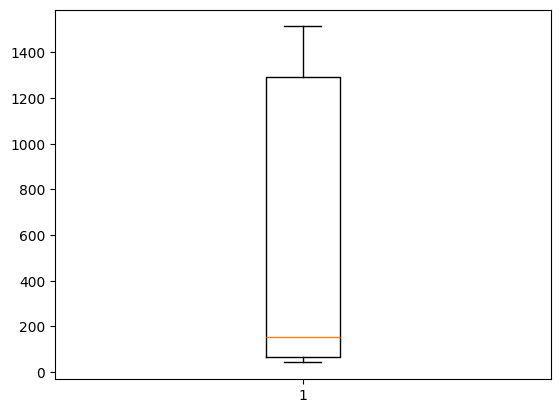

In [175]:
protocol_number = {}
protocol_length = {}
j=0
for i in df['Protocol']:
    if i not in protocol_number:
        protocol_number[i]=1
    else:
        protocol_number[i]+=1
    if i not in protocol_length:
        protocol_length[i]=df.iat[j,4]
    else:
        protocol_length[i]+=df.iat[j,4]
    j+=1
protocol_avg = {}
for i in protocol_number:
    protocol_avg[i]=(protocol_length[i]/protocol_number[i])
length_list = []
for i in protocol_avg.keys():
    length_list.append(df[df['Protocol']==i].Length)
plt.boxplot(df['Length'])

q75,q25 = np.percentile(df['Length'],[75,25])
iqr = q75 - q25
min = q25 - (iqr*1.5)
max = q75 + (iqr*1.5)
df = df.drop(df[df['Length'] < min].index)
df = df.drop(df[df['Length'] > max].index)
plt.show()

##### New Dimensions

In [176]:
df.shape

(31402, 6)

##### Data Normalisation

In [177]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(df[['Length']])
df['Length'] = scaler.transform(df[['Length']])
df.head()

,Time,Source,Destination,Protocol,Length,Info
No.,,,,,,
1,0.000000,152.195.38.76,10.87.1.105,TCP,0.012228,"80 > 61982 [FIN, ACK] Seq=1 Ack=1 Win=131 Len=0"
2,0.000123,10.87.1.105,152.195.38.76,TCP,0.008152,61982 > 80 [ACK] Seq=1 Ack=2 Win=256 Len=0
3,0.025623,10.87.1.105,192.168.1.106,TCP,0.016304,62076 > 7680 [SYN] Seq=0 Win=64240 Len=0 MSS...
4,0.027179,10.87.1.105,192.168.68.74,TCP,0.016304,62077 > 7680 [SYN] Seq=0 Win=64240 Len=0 MSS...
5,0.028677,10.87.1.105,192.168.100.21,TCP,0.016304,62078 > 7680 [SYN] Seq=0 Win=64240 Len=0 MSS...


##### Data Binning

In [178]:
df['Second-Interval'] = [math.floor(i) for i in df['Time']]
df.sample(5, random_state=420)

,Time,Source,Destination,Protocol,Length,Info,Second-Interval
No.,,,,,,,
21979,41.664957,10.87.1.105,18.143.106.89,TCP,0.008152,62289 > 443 [ACK] Seq=4284 Ack=10041 Win=655...,41
82,2.428860,35.186.241.102,10.87.1.105,TCP,0.012228,443 > 62080 [ACK] Seq=1 Ack=778 Win=67328 Len=0,2
7862,27.920184,142.250.192.36,10.87.1.105,QUIC,0.849185,Protected Payload (KP0),27
5907,26.129521,10.87.1.105,18.67.159.180,TCP,0.008152,62096 > 443 [ACK] Seq=3184 Ack=559538 Win=66...,26
24171,45.889549,185.199.111.154,10.87.1.105,TLSv1.3,1.000000,Continuation Data,45


##### Missing Value Analysis

In [179]:
df.isnull().sum()           

Time               0
Source             0
Destination        0
Protocol           0
Length             0
Info               0
Second-Interval    0
dtype: int64

Self generated dataset hence no values missing

##### Data Description

In [180]:
df.describe()

,Time,Length,Second-Interval
count,31402.000000,31402.000000,31402.000000
mean,43.279051,0.361163,42.779855
std,25.794096,0.412413,25.778744
min,0.000000,0.000000,0.000000
25%,27.916529,0.016304,27.000000
50%,36.318377,0.074728,36.000000
75%,45.622278,0.849185,45.000000
max,126.276287,1.000000,126.000000


### 2. Exploratory Analysis

##### Number of packets per protocol

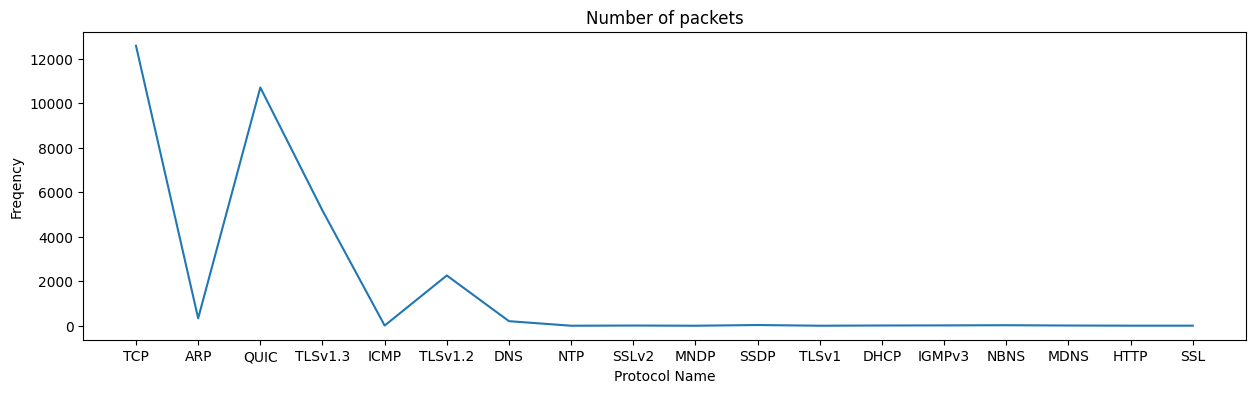

In [181]:
protocol_number = {}
for i in df['Protocol']:
    if i not in protocol_number:
        protocol_number[i]=1
    else:
        protocol_number[i]+=1
plt.figure(figsize=(15,4))
plt.plot(protocol_number.keys(),protocol_number.values())
plt.xlabel("Protocol Name")
plt.ylabel("Freqency")
plt.title("Number of packets")
plt.show()
# plt.scatter(df['NormalisedTime'],df['NormalisedLength'])

##### Average length of protocols

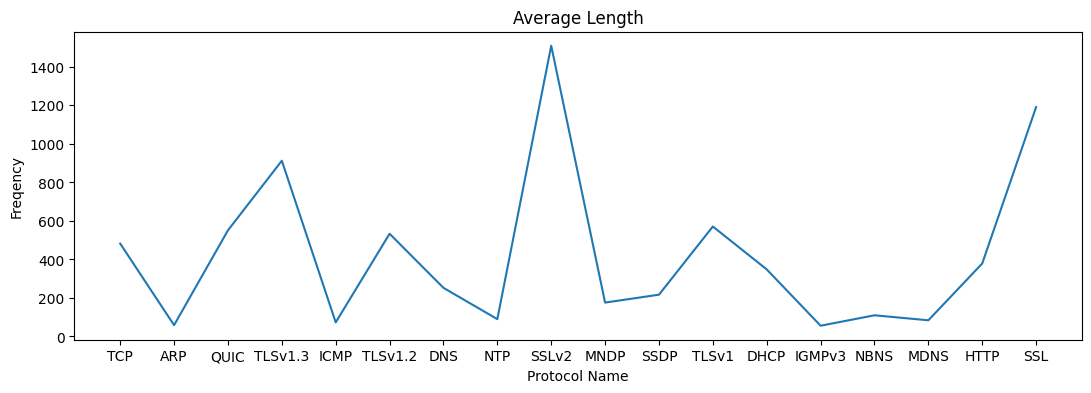

In [182]:
plt.figure(figsize=(13,4))
plt.plot(protocol_number.keys(),protocol_avg.values())
plt.xlabel("Protocol Name")
plt.ylabel("Freqency")
plt.title("Average Length")
plt.show()  

##### Heatmap for packet clustering duration

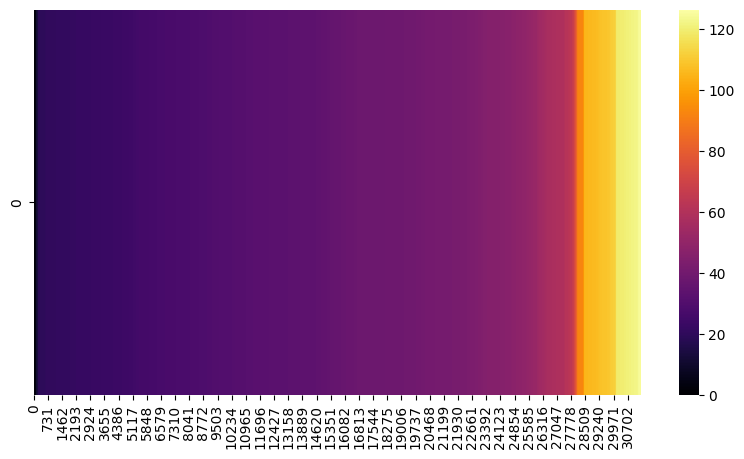

In [183]:
l1 = []
for i in df['Time']:
    l1.append(i)
hm = np.asarray(l1)
plt.figure(figsize=(9.8,5))
sb.heatmap([hm],cmap='inferno')
plt.show()

##### Histogram for packet clustering duration

Maximum traffic: 38s
Idle times: None


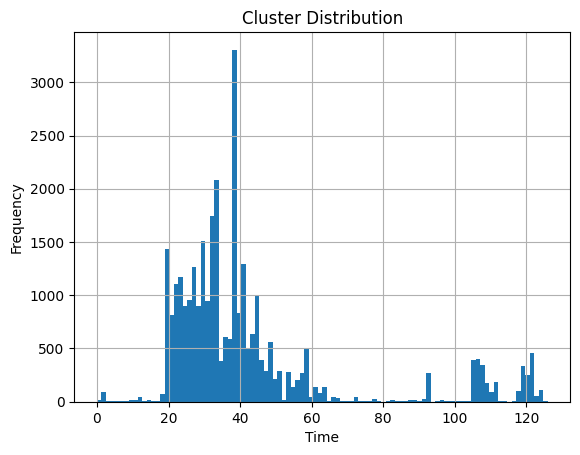

In [184]:
second_wise = df['Second-Interval'].value_counts().to_frame()
second_wise.sort_index(axis=0,ascending=True,inplace=True)
print("Maximum traffic: "+str(second_wise['count'].idxmax())+'s')
print("Idle times: ",end="")
idle = []
for i in range(0,len(second_wise)):
    if i not in second_wise.index:
        idle.append(i)
if len(idle)==0:
    print("None")
else:
    for i in idle:
        print(str(i)+"s ")
        
plt.hist(df['Second-Interval'],bins=100)
plt.grid()
plt.title("Cluster Distribution")
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.show()

##### Timeline distribution for traffic-causing protocols

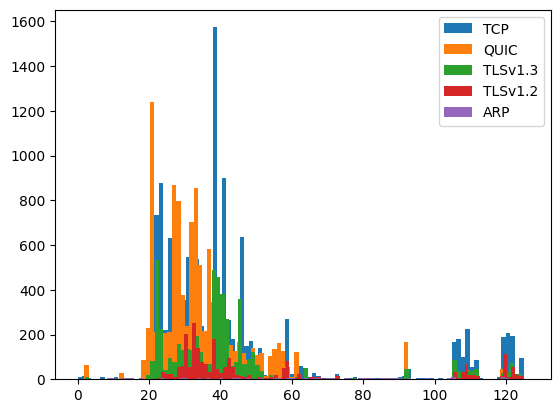

In [185]:
temp = pd.DataFrame(protocol_number,index=['Number']).T.sort_values(by='Number',ascending=False).head()
for i in temp.index:
    plt.hist(df[df['Protocol']==i].Time,bins=100,label=i)
plt.legend(loc='best')
plt.show()

#### TCP Analysis

In [186]:
tcp = df[df['Protocol']=='TCP']
tcp.tail(6)

,Time,Source,Destination,Protocol,Length,Info,Second-Interval
No.,,,,,,,
31391,124.741076,10.87.1.105,13.67.74.235,TCP,0.008152,62552 > 443 [ACK] Seq=676 Ack=6099 Win=66048...,124
31392,124.782018,13.67.74.235,10.87.1.105,TCP,0.033967,"[TCP Retransmission] 443 > 62551 [PSH, ACK] ...",124
31393,124.782059,10.87.1.105,13.67.74.235,TCP,0.016304,62551 > 443 [ACK] Seq=1983 Ack=6137 Win=6604...,124
31396,124.875606,20.198.118.190,10.87.1.105,TCP,0.110734,"[TCP Retransmission] 443 > 61035 [PSH, ACK] ...",124
31398,125.558630,157.240.16.53,10.87.1.105,TCP,0.045516,"[TCP Retransmission] 80 > 62494 [FIN, PSH, A...",125
31402,126.276287,54.201.236.40,10.87.1.105,TCP,0.137228,"[TCP Retransmission] 443 > 62100 [PSH, ACK] ...",126


##### Error Percentage

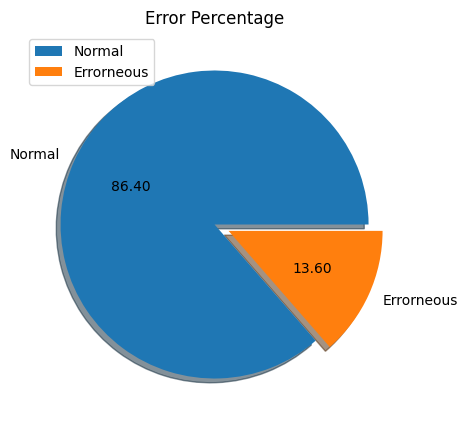

In [187]:
error = {'Retransmission':0,'Keep-Alive':0,'Dup ACK':0,'Previous':0,'Unseen':0,'Unordered':0,'Fast':0,'Spurious':0,'Window Update':0}
comp={'Normal':0,'Errorneous':0}
for i in tcp['Info']:
    if i.__contains__('Fast Retransmission'):
        error['Fast']+=1
    elif i.__contains__('Spurious'):
        error['Spurious']+=1
    elif i.__contains__('Retransmission'):
        error['Retransmission']+=1
    elif i.__contains__('Dup ACK'):
        error['Dup ACK']+=1
    elif i.__contains__('Previous segment'):
        error['Previous']+=1
    elif i.__contains__('Out-Of-Order'):
        error['Unordered']+=1
    elif i.__contains__('ACKed'):
        error['Unseen']+=1
    elif i.__contains__('Window Update'):
        error['Window Update']+=1
    elif i.__contains__('Keep-Alive'):
        error['Keep-Alive']+=1
    else:
        comp['Normal']+=1
comp['Errorneous']=len(tcp)-comp['Normal']
plt.figure(figsize=(5,5))
plt.pie(comp.values(),labels=comp.keys(),autopct='%.2f',shadow=True,explode=[0,0.1])
plt.legend(loc='best')
plt.title('Error Percentage')
plt.show()

##### Error Packets Composition

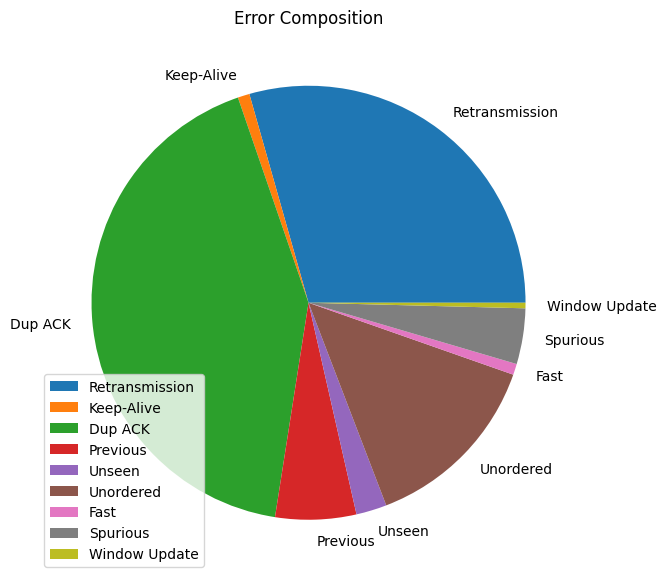

In [188]:
plt.figure(figsize=(7,10))
plt.pie(error.values(),labels=error.keys())
plt.legend(loc='best')
plt.title('Error Composition')
plt.show()

##### Bad TCP Duration

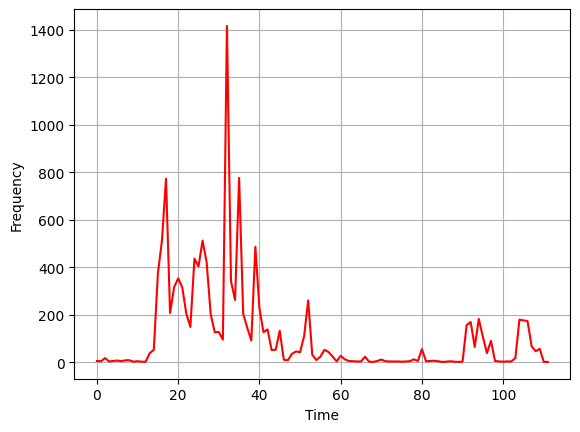

In [189]:
second_wise = {}
for i in tcp['Time']:
    j=i//1
    if j not in second_wise:
        second_wise[int(j)]=1
    else:
        second_wise[int(j)]+=1
maxn = 0
pos = ''
for i in second_wise:
    if second_wise[i]>max:
        maxn = second_wise[i]
        pos=i
plt.plot(second_wise.values(),color='red')
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.grid()
plt.show()
# print(pd.DataFrame(second_wise.values(),index=second_wise.keys()).idxmax())

#### Application Layer Analysis

In [190]:
URL = "https://en.wikipedia.org/wiki/Application_layer"
r = requests.get(URL)
l1 = {}  
soup = BeautifulSoup(r.content, 'html.parser')
table = soup.find('td',attrs={'class':'sidebar-content'})
for k in table.findAll('ul'):
    for i in k.findAll('li'):
        for j in i.findAll('a'):
            l1[j.text]=0
for i in df['Protocol']:
    if i in l1.keys():
        l1[i]+=1
temp = l1.items()
l1 = {}
for i,j in temp:
    if j!=0:
        l1[i]=j
l2={}
temp = l1.items()
for i,j in temp:
    if j!=0:
        l2[i]=j
pd.DataFrame(l1,index=['Frequency'])

,DHCP,DNS,HTTP,NTP
Frequency,12,206,4,2


##### Average length and frequencies comparisions

In [ ]:
import kaleido
dns = df[df['Protocol'] == 'DNS']
l1 = {'DNS Response': 0, 'DNS Request': 0}
l2 = {'DNS Response': 0, 'DNS Request': 0}
j = 0

for i in dns['Info']:
    if 'response' in i:
        l1['DNS Response'] += 1
        l2['DNS Response'] += dns.iat[j, 4]
    else:
        l1['DNS Request'] += 1
        l2['DNS Request'] += dns.iat[j, 4]
    j += 1

l2['DNS Request'] /= l1['DNS Request']
l2['DNS Response'] /= l1['DNS Response']

for protocol, avg_length in protocol_avg.items():
    if protocol in l2:
        l2[protocol] = avg_length

fig = go.Figure()
fig.add_trace(go.Scatterpolar(r=list(l2.values()), theta=list(l1.keys()), fill='toself', name='Average Length'))
fig.add_trace(go.Scatterpolar(r=list(l1.values()), theta=list(l1.keys()), fill='toself', name='Frequency'))
fig.update_layout(
    autosize=False,
    height=400,
    width=500,
    title={'text': 'Frequency vs Average Length'}
)

fig.write_html('figure.html')


### Some More Miscelleneous Statistics

##### Most Visited IPs through DNS

In [193]:
import socket

def resolveIP(ip):
    try:
        return socket.gethostbyaddr(ip)
    except:
        return ["Unknown"]

ip = pd.DataFrame(df['Source'].value_counts().head(10)[0:])
ip.columns = ['Frequency']
ip['Hostname'] = [resolveIP(ip)[0] for ip in ip.index]
ip.loc[ip['Hostname']!="Unknown"][1:]

,Frequency,Hostname
Source,,
18.67.159.180,1551,server-18-67-159-180.maa51.r.cloudfront.net
142.250.192.36,1482,bom12s15-in-f4.1e100.net
185.199.111.154,494,cdn-185-199-111-154.github.com
142.251.42.99,349,bom07s45-in-f3.1e100.net


##### Device IP Address

In [194]:
print(f'Device IP: {ip.index[0]}')

Device IP: 10.87.1.105


##### Maximum Type Protocol

In [195]:
max_protocol = pd.DataFrame(protocol_number,index=[0]).T.idxmax()
max_number = pd.DataFrame(protocol_number,index=[0]).T.max()
max_avglength = pd.DataFrame(protocol_avg,index=[0]).T.max()

print(f"The protocol with the maximum number of packets is {max_protocol[0]} with {max_number[0]} packets and average length of {max_avglength[0]} bytes.")

The protocol with the maximum number of packets is TCP with 12585 packets and average length of 1509.6 bytes.
